# Kalman filter implementation using torch dynamic graphs
The pytorch library is a powerful framework for designing neural network model and thanks to its dynamic compute graph capabililty one could implement almost any algorithms using torch nn.module subclass. This is an example of using torch to implement Kalman filter to remove process and measurement noise from a voltage reading.

In [6]:
import torch
import torch.nn as nn
# Initialize parameters
n_samples = 100
initial_voltage = 100.0
process_noise_stddev = 0.5
measurement_noise_stddev = 2.0

# Create synthetic voltage data set with some noise
# Generate true voltage and measurements
true_voltage = torch.zeros(n_samples)
measured_voltage = torch.zeros(n_samples)
true_voltage[0] = initial_voltage
measured_voltage[0] = initial_voltage

for n in range(1, n_samples):
    process_noise =  torch.randn(()) * process_noise_stddev
    true_voltage[n] = true_voltage[n-1] + process_noise

    measurement_noise = torch.randn(()) * measurement_noise_stddev
    measured_voltage[n] = true_voltage[n] + measurement_noise

Kalman model for a noisy 1-d measurement of a X[n] variable where the measured value is Z[n] 
$$
X[n] = X[n-1] + W[n-1]
$$

$$
Z[n] = X[n] + V[n]
$$
assuming the state transition process is 1 and `W[n]` is the process noise and `V[n]` is the measurement noise. Both are assumed to be Guassian distributed.

In [7]:
import torch
import torch.nn as nn

class KalmanFilter(nn.Module):
    def __init__(self, initial_voltage, initial_process_noise_stddev, initial_measurement_noise_stddev, learning_rate=0.01):
        super(KalmanFilter, self).__init__()
        self.estimated_voltage = initial_voltage
        self.process_noise_stddev = nn.Parameter(torch.tensor(initial_process_noise_stddev))
        self.measurement_noise_stddev = nn.Parameter(torch.tensor(initial_measurement_noise_stddev))
        self.voltage_covariance = self.process_noise_stddev ** 2
        self.learning_rate = learning_rate

    def forward(self, measurement):
        # Prediction step
        predicted_voltage = self.estimated_voltage
        predicted_covariance = self.voltage_covariance + self.process_noise_stddev ** 2

        # Update step
        kalman_gain = predicted_covariance / (predicted_covariance + self.measurement_noise_stddev ** 2)
        self.estimated_voltage = predicted_voltage + kalman_gain * (measurement - predicted_voltage)
        self.voltage_covariance = (1 - kalman_gain) * predicted_covariance

        # Update noise estimates
        self.process_noise_stddev.data += self.learning_rate * (self.voltage_covariance - self.process_noise_stddev.data ** 2).clamp(min=0).sqrt()
        self.measurement_noise_stddev.data += self.learning_rate * ((measurement - self.estimated_voltage) ** 2 - self.measurement_noise_stddev.data ** 2).clamp(min=0).sqrt()

        return self.estimated_voltage

In [8]:
# Initialize the Kalman filter with initial estimates
initial_process_noise_stddev = 0.5
initial_measurement_noise_stddev = 1.0
learning_rate = 0.01
kalman_filter = KalmanFilter(initial_voltage, initial_process_noise_stddev, initial_measurement_noise_stddev, learning_rate)

# Apply Kalman filter for each measurement
n_samples = len(measured_voltage)
estimated_voltage = torch.zeros(n_samples)
for i, measurement in enumerate(measured_voltage):
    estimated_voltage[i] = kalman_filter(measurement)

# Print results
# print("True voltage:\n", true_voltage)
# print("Measured voltage:\n", measured_voltage)
# print("Estimated voltage (Kalman filter):\n", estimated_voltage)
print("Learned process noise standard deviation:", kalman_filter.process_noise_stddev.item())
print("Learned measurement noise standard deviation:", kalman_filter.measurement_noise_stddev.item())

Learned process noise standard deviation: 0.9022875428199768
Learned measurement noise standard deviation: 1.428725004196167


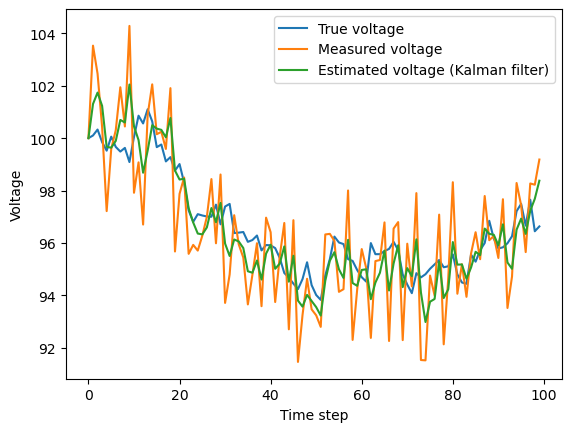

In [9]:
import matplotlib.pyplot as plt

# Detach estimated_voltage from the computation graph
estimated_voltage_detached = estimated_voltage.detach()

# Stack the data
plot_data = torch.stack([true_voltage, measured_voltage, estimated_voltage_detached], dim=1)

# Plot the data
plt.plot(plot_data)
plt.legend(["True voltage", "Measured voltage", "Estimated voltage (Kalman filter)"])
plt.xlabel("Time step")
plt.ylabel("Voltage")
plt.show()

In [10]:
def rmse(true_values, predictions):
    return torch.sqrt(torch.mean((true_values - predictions) ** 2))

# Calculate RMSE values
rmse_measured = rmse(true_voltage, measured_voltage)
rmse_estimated = rmse(true_voltage, estimated_voltage_detached)

print("RMSE between true voltage and measured voltage:", rmse_measured.item())
print("RMSE between true voltage and estimated voltage:", rmse_estimated.item())

RMSE between true voltage and measured voltage: 1.805099606513977
RMSE between true voltage and estimated voltage: 0.9253299832344055
